In [ ]:
import pandas as pd
import os
from datetime import datetime, timedelta

# Define the path to the data folder
data_folder = os.path.join("Data", "PriceData")

# Function to get the last trading day based on today's date
def get_last_trading_day(reference_date=None):
    """
    Returns the last trading day based on the reference_date.
    If today is Saturday, returns Friday.
    If today is Sunday, returns Friday.
    Otherwise, returns the previous trading day.
    """
    if reference_date is None:
        reference_date = datetime.today()
    else:
        reference_date = reference_date

    # Weekday: Monday=0, Sunday=6
    weekday = reference_date.weekday()

    if weekday == 5:  # Saturday
        last_trading_day = reference_date - timedelta(days=1)
    elif weekday == 6:  # Sunday
        last_trading_day = reference_date - timedelta(days=2)
    else:
        last_trading_day = reference_date

    # Ensure it's a weekday
    if last_trading_day.weekday() >= 5:
        # If it's Saturday or Sunday, adjust to Friday
        last_trading_day -= timedelta(days=last_trading_day.weekday() - 4)
    
    return last_trading_day.date()

# Get the expected latest trading date
expected_latest_date = get_last_trading_day()

# Get list of all .parquet files in the folder
parquet_files = [f for f in os.listdir(data_folder) if f.endswith('.parquet')]

print(f"Found {len(parquet_files)} parquet files in {data_folder}")
print(f"Expected latest trading date: {expected_latest_date}")

# Initialize lists to hold file statuses
stale_files = []
up_to_date_files = []
file_latest_dates = {}

# Iterate over each parquet file
for file in parquet_files:
    file_path = os.path.join(data_folder, file)
    try:
        # Read the parquet file
        df = pd.read_parquet(file_path)
        
        # Check if 'Date' is the index
        if isinstance(df.index, pd.DatetimeIndex):
            latest_date = df.index.max().date()
        elif 'Date' in df.columns:
            # If 'Date' is a column
            df['Date'] = pd.to_datetime(df['Date'])
            latest_date = df['Date'].max().date()
        else:
            print(f"File {file} does not have a 'Date' column or index.")
            continue
        
        # Store the latest date
        file_latest_dates[file] = latest_date
        
        # Compare with expected latest date
        if latest_date < expected_latest_date:
            stale_files.append((file, latest_date))
        else:
            up_to_date_files.append((file, latest_date))
            
    except Exception as e:
        print(f"Error processing file {file}: {e}")

# Report Up-to-date Files
print("\n=== Up-to-date Files ===")
for file, date in up_to_date_files:
    print(f"{file}: Latest date = {date}")

# Report Stale Files
print("\n=== Stale Files ===")
for file, date in stale_files:
    print(f"{file}: Latest date = {date}")

# Calculate the percentage of stale files
total_files = len(parquet_files)
stale_count = len(stale_files)
stale_percentage = (stale_count / total_files) * 100 if total_files > 0 else 0

print(f"\nOut of {total_files} files, {stale_count} are out of date.")
print(f"Percentage of stale files: {stale_percentage:.2f}%")


In [5]:
import pandas as pd

# Load the data from the parquet file
df = pd.read_parquet("_Buy_Signals.parquet")

# Remove the rows where the symbol is "INMD" or "NTLA"
df_filtered = df[~df['Symbol'].isin(['INMD', 'NTLA'])]

# Save the filtered DataFrame back to the parquet file
df_filtered.to_parquet("_Buy_Signals.parquet", index=False)

# Optional: print the tail of the updated DataFrame to confirm the changes
print(df_filtered.tail())


    Symbol LastBuySignalDate  LastBuySignalPrice  IsCurrentlyBought  \
246   BCDA        2024-10-10            2.782500              False   
247   KIRK        2024-10-16            2.037000              False   
248   VTYX        2024-10-16            2.457000              False   
249    WBA        2024-10-16           10.941000              False   
252   PZZA        2024-10-21           54.560001              False   

     ConsecutiveLosses LastTradedDate  UpProbability LastSellPrice  \
246                  0     2024-10-21         0.6446          None   
247                  0     2024-10-21         0.6441          None   
248                  0            NaT         0.6591          None   
249                  0            NaT         0.6895          None   
252                  0            NaT         0.6801          None   

     PositionSize  
246           NaN  
247           NaN  
248           NaN  
249           NaN  
252           NaN  


In [ ]:
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from scipy.signal import welch
from scipy.stats import entropy, spearmanr
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings('ignore')

# Define helper functions for noise calculation
def calculate_spectral_slope(y, fs=1.0):
    freqs, psd = welch(y, fs=fs, nperseg=min(256, len(y)))
    freqs = freqs[1:]
    psd = psd[1:] + 1e-10  # Prevent log(0)
    log_freqs = np.log(freqs)
    log_psd = np.log(psd)
    if len(log_freqs) < 2 or len(log_psd) < 2:
        return np.nan
    slope, _ = np.polyfit(log_freqs, log_psd, 1)
    return slope

def calculate_hurst_exponent(ts):
    lags = range(2, min(100, len(ts)//2))
    tau = [np.sqrt(np.std(ts[lag:] - ts[:-lag])) for lag in lags if np.std(ts[lag:] - ts[:-lag]) > 0]
    tau = np.array(tau)
    if len(tau) < 2:
        return np.nan
    return np.polyfit(np.log(lags[:len(tau)]), np.log(tau), 1)[0] * 2.0

def calculate_spectral_entropy(y, fs=1.0, nperseg=256):
    freqs, psd = welch(y, fs=fs, nperseg=min(nperseg, len(y)))
    psd_norm = psd / np.sum(psd) + 1e-10
    return entropy(psd_norm)

def calculate_autocorrelation(y, lag=1):
    return spearmanr(y[:-lag], y[lag:]).correlation if len(y) > lag else np.nan

# Enhanced randomness filter function
def enhanced_randomness_filter(df, window_size=20, data_removal_target=0.10):
    df = df.copy()
    df['Return'] = df['Close'].pct_change().replace([np.inf, -np.inf], np.nan).dropna()

    metrics = {'Spectral_Slope': [], 'Spectral_Entropy': [], 'Hurst_Exponent': [], 'Autocorrelation': []}
    
    # Pad the metrics with NaN at the start
    for key in metrics:
        metrics[key] = [np.nan] * (window_size - 1)

    # Iterate over the rolling window to calculate noise metrics
    for i in range(window_size, len(df) + 1):
        window = df['Return'].iloc[i - window_size:i].values
        if np.all(np.isfinite(window)):
            window_norm = MinMaxScaler().fit_transform(window.reshape(-1, 1)).flatten()
            metrics['Spectral_Slope'].append(calculate_spectral_slope(window_norm))
            metrics['Spectral_Entropy'].append(calculate_spectral_entropy(window_norm))
            metrics['Hurst_Exponent'].append(calculate_hurst_exponent(window_norm))
            metrics['Autocorrelation'].append(calculate_autocorrelation(window_norm))
        else:
            for key in metrics:
                metrics[key].append(np.nan)

    # Add the metrics back to the DataFrame
    for key, values in metrics.items():
        df[key] = values

    # Filter the DataFrame based on the calculated metrics
    df_filtered = df.dropna(subset=metrics.keys()).copy()

    return df_filtered, df[metrics.keys()]


# Load Data (replace file paths with your own)
data_dir = 'Data/PriceData'
file_paths = [os.path.join(data_dir, f) for f in os.listdir(data_dir) if f.endswith('.parquet')]

# Load and process one file for exploratory analysis
df = pd.read_parquet(file_paths[0])

# Apply the randomness filter to the data
window_size = 20
data_removal_target = 0.10

filtered_df, noise_metrics_df = enhanced_randomness_filter(df, window_size=window_size, data_removal_target=data_removal_target)

# Plot noise metrics using seaborn
plt.figure(figsize=(16, 12))

# Plot Spectral Slope
plt.subplot(2, 2, 1)
sns.histplot(noise_metrics_df['Spectral_Slope'].dropna(), kde=True, bins=30, color='blue')
plt.title('Spectral Slope Distribution')

# Plot Spectral Entropy
plt.subplot(2, 2, 2)
sns.histplot(noise_metrics_df['Spectral_Entropy'].dropna(), kde=True, bins=30, color='green')
plt.title('Spectral Entropy Distribution')

# Plot Hurst Exponent
plt.subplot(2, 2, 3)
sns.histplot(noise_metrics_df['Hurst_Exponent'].dropna(), kde=True, bins=30, color='red')
plt.title('Hurst Exponent Distribution')

# Plot Autocorrelation
plt.subplot(2, 2, 4)
sns.histplot(noise_metrics_df['Autocorrelation'].dropna(), kde=True, bins=30, color='purple')
plt.title('Autocorrelation Distribution')

plt.tight_layout()
plt.show()

# Summary statistics for noise metrics
print(noise_metrics_df.describe())

# Correlation matrix of noise metrics
plt.figure(figsize=(10, 8))
sns.heatmap(noise_metrics_df.corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix of Noise Metrics')
plt.show()


In [ ]:
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from scipy.signal import welch
from scipy.stats import entropy, spearmanr
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings('ignore')

# Define helper functions for noise calculation
def calculate_spectral_slope(y, fs=1.0):
    freqs, psd = welch(y, fs=fs, nperseg=min(256, len(y)))
    freqs = freqs[1:]
    psd = psd[1:] + 1e-10  # Prevent log(0)
    log_freqs = np.log(freqs)
    log_psd = np.log(psd)
    if len(log_freqs) < 2 or len(log_psd) < 2:
        return np.nan
    slope, _ = np.polyfit(log_freqs, log_psd, 1)
    return slope

def calculate_hurst_exponent(ts):
    lags = range(2, min(100, len(ts)//2))
    tau = [np.sqrt(np.std(ts[lag:] - ts[:-lag])) for lag in lags if np.std(ts[lag:] - ts[:-lag]) > 0]
    tau = np.array(tau)
    if len(tau) < 2:
        return np.nan
    return np.polyfit(np.log(lags[:len(tau)]), np.log(tau), 1)[0] * 2.0

def calculate_spectral_entropy(y, fs=1.0, nperseg=256):
    freqs, psd = welch(y, fs=fs, nperseg=min(nperseg, len(y)))
    psd_norm = psd / np.sum(psd) + 1e-10
    return entropy(psd_norm)

def calculate_autocorrelation(y, lag=1):
    return spearmanr(y[:-lag], y[lag:]).correlation if len(y) > lag else np.nan

# Enhanced randomness filter function
def enhanced_randomness_filter(df, window_size=20, data_removal_target=0.10):
    df = df.copy()
    df['Return'] = df['Close'].pct_change().replace([np.inf, -np.inf], np.nan).dropna()

    metrics = {'Spectral_Slope': [], 'Spectral_Entropy': [], 'Hurst_Exponent': [], 'Autocorrelation': []}
    
    # Pad the metrics with NaN at the start
    for key in metrics:
        metrics[key] = [np.nan] * (window_size - 1)

    # Iterate over the rolling window to calculate noise metrics
    for i in range(window_size, len(df) + 1):
        window = df['Return'].iloc[i - window_size:i].values
        if np.all(np.isfinite(window)):
            window_norm = MinMaxScaler().fit_transform(window.reshape(-1, 1)).flatten()
            metrics['Spectral_Slope'].append(calculate_spectral_slope(window_norm))
            metrics['Spectral_Entropy'].append(calculate_spectral_entropy(window_norm))
            metrics['Hurst_Exponent'].append(calculate_hurst_exponent(window_norm))
            metrics['Autocorrelation'].append(calculate_autocorrelation(window_norm))
        else:
            for key in metrics:
                metrics[key].append(np.nan)

    # Add the metrics back to the DataFrame
    for key, values in metrics.items():
        df[key] = values

    # Filter the DataFrame based on the calculated metrics
    df_filtered = df.dropna(subset=metrics.keys()).copy()

    return df_filtered, df[metrics.keys()]

# Load all files and process them
data_dir = 'Data/PriceData'
file_paths = [os.path.join(data_dir, f) for f in os.listdir(data_dir) if f.endswith('.parquet')]

# Initialize an empty DataFrame to store noise metrics from all files
all_noise_metrics = pd.DataFrame()

# Loop over all files and apply the randomness filter
# Limit the number of files to process to 20
file_paths_to_process = file_paths[:100]

for file_path in file_paths_to_process:
    df = pd.read_parquet(file_path)

    # Apply the randomness filter to the data
    window_size = 20
    data_removal_target = 0.10

    filtered_df, noise_metrics_df = enhanced_randomness_filter(df, window_size=window_size, data_removal_target=data_removal_target)

    # Append noise metrics to the combined DataFrame
    all_noise_metrics = pd.concat([all_noise_metrics, noise_metrics_df], ignore_index=True)

# Remove any rows with NaN values in the noise metrics (optional)
all_noise_metrics.dropna(inplace=True)

# Plot noise metrics for all files
plt.figure(figsize=(16, 12))

# Plot Spectral Slope
plt.subplot(2, 2, 1)
sns.histplot(all_noise_metrics['Spectral_Slope'].dropna(), kde=True, bins=30, color='blue')
plt.title('Spectral Slope Distribution (All Files)')

# Plot Spectral Entropy
plt.subplot(2, 2, 2)
sns.histplot(all_noise_metrics['Spectral_Entropy'].dropna(), kde=True, bins=30, color='green')
plt.title('Spectral Entropy Distribution (All Files)')

# Plot Hurst Exponent
plt.subplot(2, 2, 3)
sns.histplot(all_noise_metrics['Hurst_Exponent'].dropna(), kde=True, bins=30, color='red')
plt.title('Hurst Exponent Distribution (All Files)')

# Plot Autocorrelation
plt.subplot(2, 2, 4)
sns.histplot(all_noise_metrics['Autocorrelation'].dropna(), kde=True, bins=30, color='purple')
plt.title('Autocorrelation Distribution (All Files)')

plt.tight_layout()
plt.show()

# Summary statistics for noise metrics across all files
print(all_noise_metrics.describe())

# Correlation matrix of noise metrics across all files
plt.figure(figsize=(10, 8))
sns.heatmap(all_noise_metrics.corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix of Noise Metrics (All Files)')
plt.show()


Processing files: 100%|██████████| 4313/4313 [00:17<00:00, 243.24file/s]


Anomalous Files Detected:


,Start Date,End Date
ADC-PA.parquet,2023-08-08,2024-10-30
AL-PA.parquet,2023-08-07,2024-10-16
AMLX.parquet,2023-08-11,2024-10-30
AUGX.parquet,2023-08-07,2024-10-02
BAC-PS.parquet,2023-08-31,2024-10-30
CEG.parquet,2023-08-22,2024-10-30
CHUY.parquet,2023-08-07,2024-10-11
CRDO.parquet,2023-08-30,2024-10-30
CSR-PC.parquet,2023-08-07,2024-09-27
DMA.parquet,2023-08-17,2024-10-30


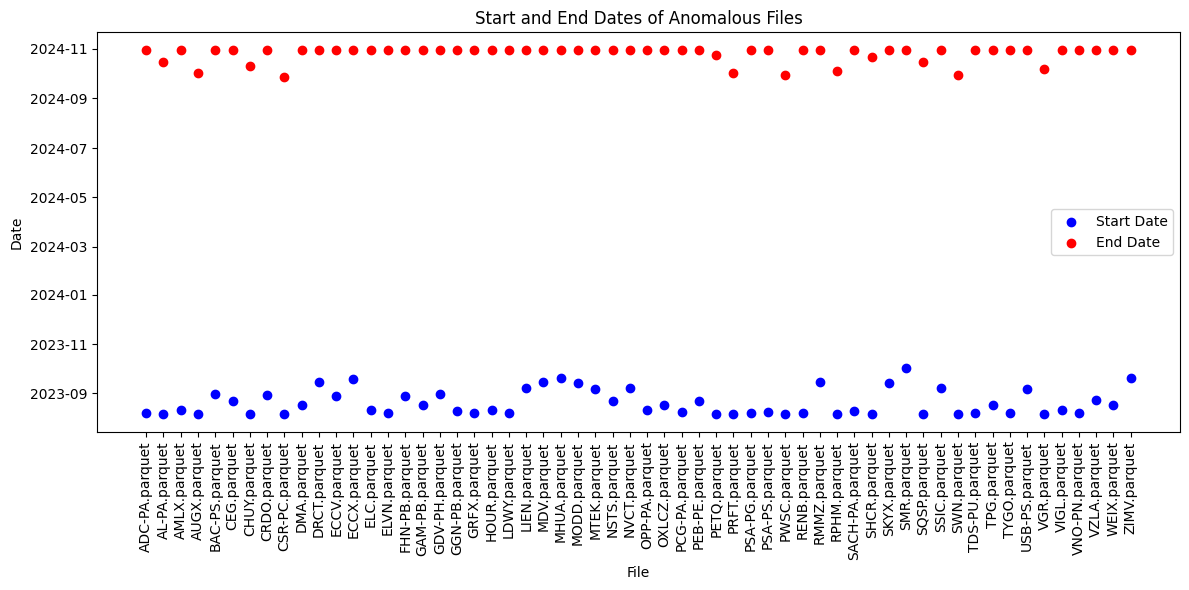

In [1]:
# Import required libraries
import os
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

# Folder path for the data files
folder_path = "Data/RFpredictions"

# Initialize a list to hold the date ranges of each file
date_ranges = {}

# Define the latest date to check for consistency
latest_date = pd.Timestamp("2024-10-30")

# Load all Parquet files and check their date ranges
files = [f for f in os.listdir(folder_path) if f.endswith(".parquet")]
total_files = len(files)

# Progress bar setup with tqdm
with tqdm(total=total_files, desc="Processing files", unit="file") as pbar:
    for file in files:
        # Read the Parquet file
        file_path = os.path.join(folder_path, file)
        df = pd.read_parquet(file_path)
        
        # Check the date range
        start_date = df["Date"].min()
        end_date = df["Date"].max()
        
        # Store the date range
        date_ranges[file] = (start_date, end_date)
        
        # Update the progress bar
        pbar.update(1)

# Convert date_ranges to a DataFrame for easier analysis
date_ranges_df = pd.DataFrame(date_ranges, index=["Start Date", "End Date"]).T

# Detect the common start and end dates across most files
most_common_start = date_ranges_df["Start Date"].mode()[0]
most_common_end = date_ranges_df["End Date"].mode()[0]

# Identify anomalous files
anomalous_files = date_ranges_df[
    (date_ranges_df["Start Date"] != most_common_start) | 
    (date_ranges_df["End Date"] != most_common_end)
]

# Display only the anomalous files
if not anomalous_files.empty:
    print("Anomalous Files Detected:")
    display(anomalous_files)
    
    # Plot the start and end dates of the anomalous files
    plt.figure(figsize=(12, 6))
    
    # Plot start dates
    plt.scatter(anomalous_files.index, anomalous_files['Start Date'], color='blue', label='Start Date')
    
    # Plot end dates
    plt.scatter(anomalous_files.index, anomalous_files['End Date'], color='red', label='End Date')
    
    # Formatting the plot
    plt.xlabel('File')
    plt.ylabel('Date')
    plt.xticks(rotation=90)
    plt.legend()
    plt.title('Start and End Dates of Anomalous Files')
    
    # Show plot
    plt.tight_layout()
    plt.show()

else:
    print("No anomalies found. All files have consistent date ranges.")


In [2]:
import os

# Define the folder where the .parquet files are stored
folder_path = os.path.join("Data", "RFpredictions")

# List of money market fund and index tickers to blacklist
blacklist_tickers = [
    # Fidelity Money Market Funds
    "FDRXX", "SPRXX", "FZFXX", "FZDXX", "FNSXX",
    
    # BlackRock Money Market Funds
    "BIL", "ICSH", "MINT",
    
    # Vanguard Money Market Funds
    "VMFXX", "VMRXX", "VUSXX",
    
    # Charles Schwab Money Market Funds
    "SWVXX", "SNAXX",
    
    # T. Rowe Price Money Market Funds
    "PRRXX", "TSCXX",
    
    # JPMorgan Money Market Funds
    "JPST", "JPMXX",
    
    # Goldman Sachs Money Market Funds
    "GSMMF", "GSY",
    
    # Invesco Money Market Funds
    "GSY", "PVI",
    
    # Major Indexes
    "DIA", "SPY", "IVV", "VOO",  # S&P 500
    "QQQ",                        # Nasdaq 100
    "IWM",                        # Russell 2000
    "IWB",                        # Russell 1000
    "MDY",                        # S&P MidCap 400
    "ISF.L",                      # FTSE 100
    "EEM", "IEMG",                # MSCI Emerging Markets
    "URTH", "ACWI",               # MSCI World
    "VTI", "ITOT", "SCHB",        # Total Stock Market
    
    # Sector-based ETFs
    "XLF", "XLE", "XLK", "XLY",   # Financials, Energy, Tech, Consumer Discretionary
    "XLV", "XLI", "XLB", "XLU",   # Health Care, Industrials, Materials, Utilities
    "XLC", "XLP", "XLRE",         # Communication Services, Consumer Staples, Real Estate
    
    # Bond ETFs
    "AGG", "BND", "TLT", "SHY",   # US Aggregate, Total Bond, Long-Term Treasuries, Short-Term Treasuries
    
    # Commodity Funds
    "GLD", "IAU", "SLV", "USO",   # Gold, Silver, Oil
    "DBC", "PALL",                # Broad Commodities, Palladium
    
    # Real Estate Investment Trusts (REITs) and Real Estate Funds
    "VNQ", "IYR", "SCHH",         # US REIT, iShares US Real Estate, Schwab US REIT
    
    # International ETFs
    "FXI", "EWJ", "EFA", "EWZ",   # China, Japan, EAFE (Developed), Brazil
    "VEA", "VWO", "SPDW",         # Developed Markets, Emerging Markets
    
    # Leveraged/Inverse ETFs (non-real companies)
    "TQQQ", "SQQQ", "SPXL", "SPXS", # Triple-Leveraged and Inverse ETFs
    "UVXY", "SVXY",                # VIX-related ETFs
    "UPRO", "SDOW",                # S&P 500 3x, Dow Inverse
    
    # Smaller Canadian Money Market Funds and Bank ETFs
    "ZMMK", "PSA", "CSAV", "HSAV", "HSUV.U", "CMR", "RMM.UN",
    
    # U.S. Smaller Money Market and Bond Funds
    "NEAR", "SHV", "ICVT", "FTSL", "FLRN", "VRP", "JPUL",
    
    # Regional or Niche Financial Institution Money Market Funds
    "TFLO", "GBIL", "FLOT"



    # Leveraged ETFs
    "TQQQ", "SQQQ", "UPRO", "SDOW", "SPXL", "SPXS", "UVXY", "SVXY",

    # Inverse ETFs
    "SH", "DOG", "PSQ", "SDS", "QID", "TZA", "DUST", "FAZ", "SOXS",

    # Commodities and Futures ETFs
    "OIL", "USO", "UGA", "DBO", "UNG", "GLD", "SLV", "PALL", "PLTM", "DBB", "WEAT", "CORN",

    # Convertible Bond ETFs
    "ICVT", "VRP", "CWB",

    # Treasury Bonds/Inflation-Protected Bonds
    "TIP", "TLT", "SHV", "IEF", "BND", "AGG", "LTPZ", "STIP",

    # Sector ETFs
    "XLF", "XLE", "XLK", "XLY", "XLV", "XLI", "XLB", "XLU", "XLC", "XLP", "XLRE",

    # Short-Term Bond Funds
    "SHV", "NEAR", "MINT", "JPST", "BIL", "ICSH", "FLRN", "GBIL", "TFLO", "FLOT",

    # Other potential non-company assets
    "VNQ", "IYR", "SCHH", "FXI", "EWJ", "EFA", "EWZ", "VEA", "VWO", "SPDW", "RMM.UN", "CSAV", "HSAV"


    #sorta failing companies
    "NKLA",  # Nikola
    "RIDE",  # Lordstown Motors
    "PTON",  # Peloton
    "BBBY",  # Bed Bath & Beyond
    "WE",    # WeWork
    "SPCE",  # Virgin Galactic
    "GOEV",  # Canoo
    #"BYND",  # Beyond Meat
    #"AMC",   # AMC Entertainment
    "APRN",  # Blue Apron
    "CLOV",  # Clover Health
    "WISH"   # Wish (ContextLogic)



    #weird ones 

    "ZION",  # Zions Bancorporation (historically tied to the LDS church)
    "CXW",   # CoreCivic (formerly Corrections Corporation of America, private prison ties)
    "GEO",   # GEO Group (another private prison company)
    "KOCH",  # Koch Industries (owned by Koch brothers with significant political influence)
    "HES",   # Hess Corporation (historically had controversial family ownership with ties to political influence)
    "BYND",  # Beyond Meat (due to ties with plant-based agenda and polarizing eco-movement connections)
    "BUD",   # Anheuser-Busch (ties to controversial marketing decisions in recent years)
    "PNRA"   # Panera Bread (historically connected to controversial political donations)


]



# Delete files that match the blacklist tickers
deleted_files = 0

for ticker in blacklist_tickers:
    file_path = os.path.join(folder_path, f"{ticker}.parquet")
    
    if os.path.exists(file_path):
        os.remove(file_path)
        deleted_files += 1
        print(f"Deleted: {file_path}")
    else:
        print(f"File not found for ticker: {ticker}")

print(f"Total files deleted: {deleted_files}")


File not found for ticker: FDRXX
File not found for ticker: SPRXX
File not found for ticker: FZFXX
File not found for ticker: FZDXX
File not found for ticker: FNSXX
File not found for ticker: BIL
File not found for ticker: ICSH
File not found for ticker: MINT
File not found for ticker: VMFXX
File not found for ticker: VMRXX
File not found for ticker: VUSXX
File not found for ticker: SWVXX
File not found for ticker: SNAXX
File not found for ticker: PRRXX
File not found for ticker: TSCXX
File not found for ticker: JPST
File not found for ticker: JPMXX
File not found for ticker: GSMMF
File not found for ticker: GSY
File not found for ticker: GSY
File not found for ticker: PVI
File not found for ticker: DIA
File not found for ticker: SPY
File not found for ticker: IVV
File not found for ticker: VOO
File not found for ticker: QQQ
File not found for ticker: IWM
File not found for ticker: IWB
File not found for ticker: MDY
File not found for ticker: ISF.L
File not found for ticker: EEM
File n